In [5]:
import sys
from pathlib import Path
sys.path.append("../src/")
sys.path.append("../src/AtomicH")
sys.path.append("../src/AtomicH/LitReview")
import numpy as np
import pylab as plt
import json
import os
import elastic
import constants
import potentials
import dipolelosses
from dipolelosses import DipoleChannels
import spinexchange
from spinexchange import SpinExChannels


try:
    here = Path(__file__).resolve().parent
except NameError:
    here = Path.cwd()              

src_root = (here / ".." / "src").resolve()
if str(src_root) not in sys.path:    
    sys.path.insert(0, str(src_root))

In [6]:
k_A  = np.linspace(1e-4, 4*constants.hcInEVAngstrom, 200)      
k_eV = k_A / constants.hcInEVAngstrom           

In [7]:
r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos = np.linspace(r0, intlimit, 100)

muH=constants.HydrogenConstants.mu
muT=constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)   

sigma_T_by_l = {}               
sigma_T_total = np.zeros_like(k_A)   # activate if you want Σ_l

for l in even_ls:
    sigma_T_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muT,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_T_by_l[l] = sigma_T_partial 
    sigma_T_total   += sigma_T_by_l[l]       

In [8]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Al_Maaitah.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

Al_Maaitah        = data["datasetColl"][0]["data"]     # first dataset in the file
k        = np.array([pt["value"][0] for pt in Al_Maaitah])   # Å⁻¹
XS      = np.array([pt["value"][1] for pt in Al_Maaitah])   # Å²

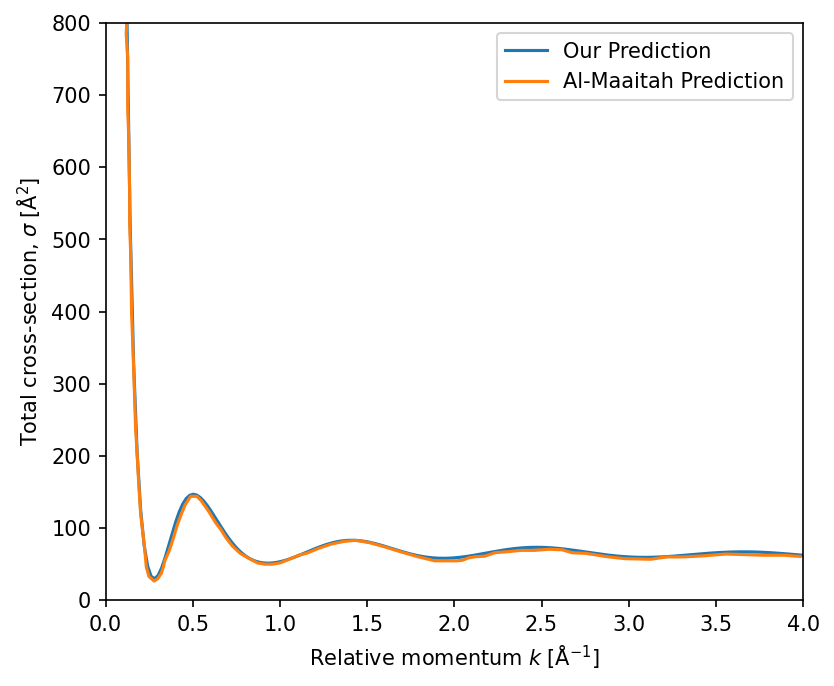

In [9]:
plt.figure(figsize=(6,5), dpi=150)
plt.plot(k_eV, np.array(sigma_T_total) * constants.hcInEVAngstrom**2, label="Our Prediction")  
plt.plot(k,XS, label="Al-Maaitah Prediction")
plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel(r'Total cross-section, $\sigma\;[\mathrm{\AA}^{2}]$')
plt.xlim(0, 4)
plt.ylim(0, 800)
plt.legend()

In [10]:
B_values = np.logspace(-3,1,50)

T        = 5e-4

GVsB_HDip=[]
GVsB_TDip=[]

for c in DipoleChannels:
    Gs=[]
    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.HydrogenConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_HDip.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.TritiumConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_TDip.append(np.array(Gs))

/Users/benjpjones/PycharmProjects/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/benjpjones/PycharmProjects/AtomicHScattering/examples/../src/AtomicH/spinbasis.py:283: RuntimeWarning: divide by zero encountered in matmul
  Rets[m]=TransformMatrix(np.matmul(np.matmul(TripletProj,SigMatrix),TripletProj),Rotator)
/Users/benjpjones/PycharmProjects/AtomicHScattering/examples/../src/AtomicH/spinbasis.py:283: RuntimeWarning: overflow encountered in matmul
  Ret

In [11]:
potT     = potentials.Silvera_Triplet
potS     = potentials.Kolos_SingletCombo

T        = 1e-5

GVsB_HEx=[]
GVsB_TEx=[]

for c in SpinExChannels:
    Gs=[]
    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.HydrogenConstants, T, potT,potS,np.linspace(1e-9,0.75,20000)))
    GVsB_HEx.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.TritiumConstants, T, potT,potS,np.linspace(1e-9,0.75,20000)))
    GVsB_TEx.append(np.array(Gs))

In [12]:
# To make the plots with real B on x axis
#B_display=B_values

# To make the plots with Stoof scaled B on x axis
B_display=dipolelosses.B_Naught(B_values)

In [13]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_Ex_and_aa_ad.json"
)
with open(json_path, "r") as f:
    data = json.load(f)
    
ccaa        = data["datasetColl"][0]["data"]    
B_ccaa        = np.array([pt["value"][0] for pt in ccaa])  
G_ccaa     = np.array([pt["value"][1] for pt in ccaa])  

ccbd        = data["datasetColl"][1]["data"]    
B_ccbd        = np.array([pt["value"][0] for pt in ccbd])  
G_ccbd     = np.array([pt["value"][1] for pt in ccbd])  

ccac      = data["datasetColl"][2]["data"]    
B_ccac        = np.array([pt["value"][0] for pt in ccac])  
G_ccac     = np.array([pt["value"][1] for pt in ccac])  

ddaa        = data["datasetColl"][3]["data"]    
B_ddaa        = np.array([pt["value"][0] for pt in ddaa])  
G_ddaa     = np.array([pt["value"][1] for pt in ddaa])   

ddad        = data["datasetColl"][4]["data"]    
B_ddad      = np.array([pt["value"][0] for pt in ddad])  
G_ddad     = np.array([pt["value"][1] for pt in ddad])   

In [14]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_Dip_ac.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

ddac       = data["datasetColl"][0]["data"]    
B_ddac        = np.array([pt["value"][0] for pt in ddac])  
G_ddac     = np.array([pt["value"][1] for pt in ddac])   

In [15]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_Dip_cd_cc.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

ddcc       = data["datasetColl"][0]["data"]    
B_ddcc        = np.array([pt["value"][0] for pt in ddcc])  
G_ddcc     = np.array([pt["value"][1] for pt in ddcc])  

ddcd       = data["datasetColl"][1]["data"]    
B_ddcd        = np.array([pt["value"][0] for pt in ddcd])  
G_ddcd     = np.array([pt["value"][1] for pt in ddcd])  

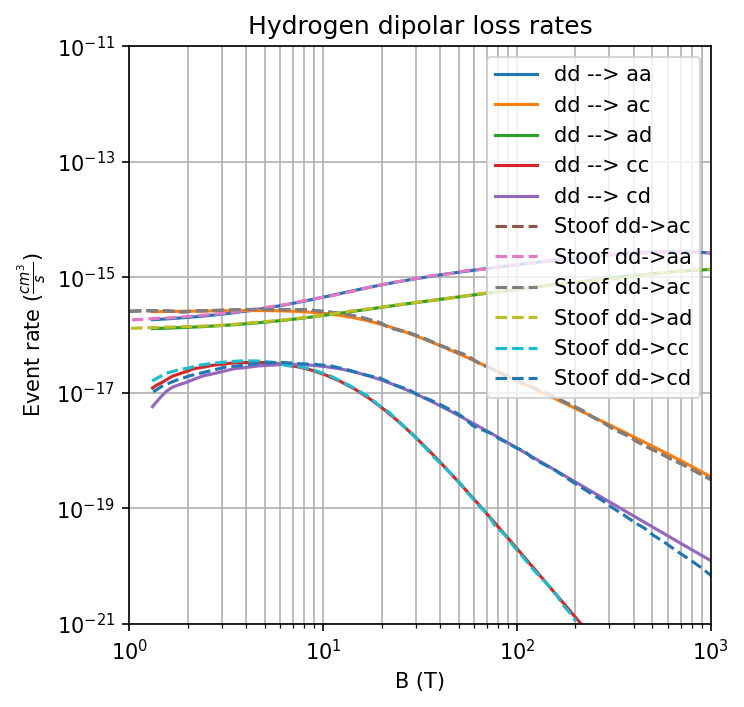

In [16]:
plt.figure(figsize=(5,5),dpi=150)

for ci in range(0,len(DipoleChannels)):
    Label='dd --> '+str(DipoleChannels[ci]['alphaprime'])+str(DipoleChannels[ci]['betaprime'])
    plt.plot(B_display,GVsB_HDip[ci],label=Label)
    plt.semilogy()

plt.plot(B_ddac,G_ddac,'--',label="Stoof dd->ac")
plt.plot(B_ddaa,G_ddaa,'--',label="Stoof dd->aa")
plt.plot(B_ddac,G_ddac,'--',label="Stoof dd->ac")
plt.plot(B_ddad,G_ddad,'--',label="Stoof dd->ad")
plt.plot(B_ddcc,G_ddcc,'--',label="Stoof dd->cc")
plt.plot(B_ddcd,G_ddcd,'--',label="Stoof dd->cd")

plt.xlabel("B (T)")
plt.xlim(1, 1e3)
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21, 1e-11)
plt.title("Hydrogen dipolar loss rates")
plt.grid(which='both')
plt.legend()
plt.loglog()
plt.show()

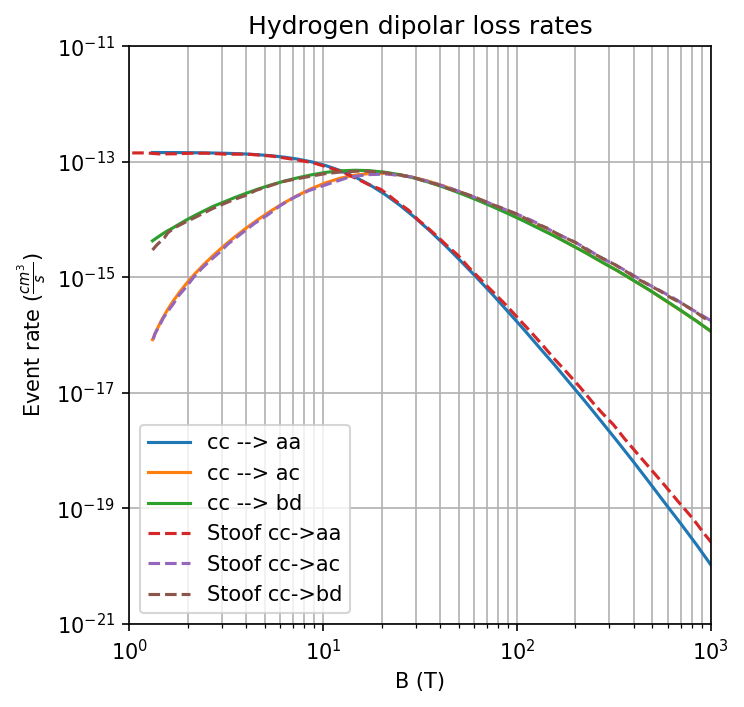

In [17]:
plt.figure(figsize=(5,5),dpi=150)

for ci in range(0,len(SpinExChannels)):
    Label='cc --> '+str(SpinExChannels[ci]['alphaprime'])+str(SpinExChannels[ci]['betaprime'])
    plt.plot(B_display, GVsB_HEx[ci],label=Label)
    plt.semilogy()

plt.plot(B_ccaa,G_ccaa,'--',label="Stoof cc->aa")
plt.plot(B_ccac,G_ccac,'--',label="Stoof cc->ac")
plt.plot(B_ccbd,G_ccbd,'--',label="Stoof cc->bd")

plt.xlabel("B (T)")
plt.xlim(1, 1e3)
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21, 1e-11)
plt.title("Hydrogen dipolar loss rates")
plt.grid(which='both')
plt.legend()
plt.loglog()
plt.show()

In [18]:
c=DipoleChannels[0]

B_values = np.logspace(-3,100,50)

pot      = potentials.Silvera_Triplet
T_values = np.logspace(-3,2,50)
B_value  = 1e-5

SummedG=[]
for T in T_values:
    SummedG.append(dipolelosses.GetSummedGFactor(c, B_value, constants.HydrogenConstants, T, pot,rhos=np.linspace(1e-9,0.75,2000)))
SummedG=np.array(SummedG)

In [19]:
GVsB_PW_H=[]
PWaves=[[0,2],
        [2,0],
        [2,2],
        [2,4],
        [4,2],
        [4,4],
        [4,6]]

degeneracies1 = [1,
                1/5,
                3/5,
                1,
                5/9,
                7/9,
                1]



for PW in PWaves:
    Gs=[]
    for T in T_values:
        Gs.append(dipolelosses.GetGFactor(c,  B_value, constants.HydrogenConstants, T, pot,rhos=np.linspace(1e-9,0.75,2000),lin=PW[0],lout=PW[1]))
    GVsB_PW_H.append(np.array(Gs))

In [20]:
amu=1.672621925e-27
A = 1e-6 / (constants.BohrInAng*1e-10)**2 * np.sqrt(amu/(4*constants.kb))

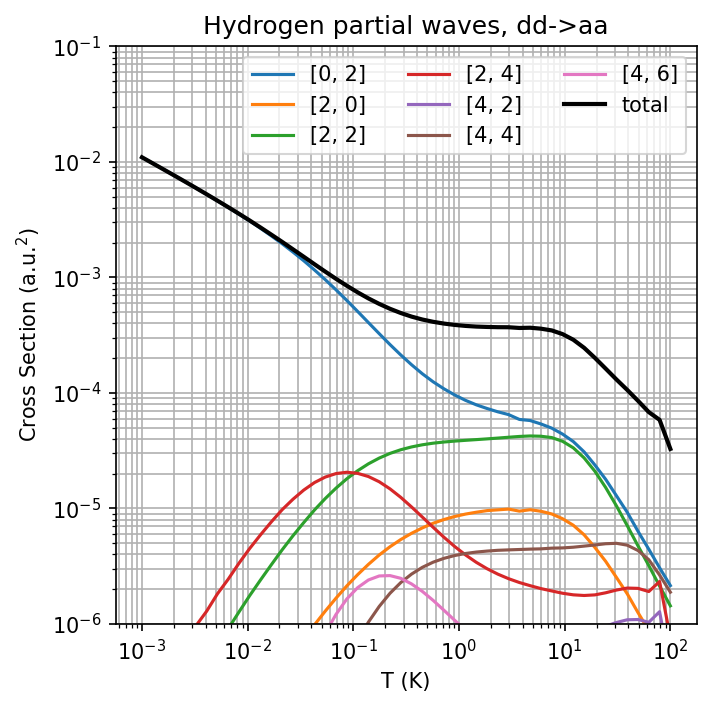

In [21]:
plt.figure(figsize=(5,5),dpi=150)
for iPW in range(0,len(PWaves)):
    plt.plot(T_values,A*GVsB_PW_H[iPW]*degeneracies1[iPW]/np.sqrt(T_values),label=str(PWaves[iPW]))
plt.plot(T_values, A*SummedG/np.sqrt(T_values),linewidth=2,color='black',label='total')
plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')
#plt.ylim(1e-19, 1e-15)
plt.title("Hydrogen partial waves, dd->aa")
plt.grid(which='both')
plt.legend(ncol=3)
plt.loglog()
plt.ylim(1e-6,1e-1)

plt.show()

In [22]:
degeneracies2 = [1,
                1,
                1,
                1,
                1,
                1,
                1]

degeneracies3 = [1,
                0,
                0,
                0,
                0,
                0,
                0]

SumPW1=np.zeros_like(GVsB_PW_H[0])
SumPW2=np.zeros_like(GVsB_PW_H[0])
SumPW3=np.zeros_like(GVsB_PW_H[0])

In [23]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zyg_1.b.json"
)

with open(json_path, "r") as f:
    data = json.load(f)
    
Zygaa        = data["datasetColl"][0]["data"]    
ZygaaK        = np.array([pt["value"][0] for pt in Zygaa])  
ZygaaSig     = np.array([pt["value"][1] for pt in Zygaa])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zyg_1.a.json"
)

with open(json_path, "r") as f:
    data = json.load(f)
    
Zygad        = data["datasetColl"][0]["data"]    
ZygKad        = np.array([pt["value"][0] for pt in Zygad])  
ZygadSig     = np.array([pt["value"][1] for pt in Zygad])  

mp = 1.672621925e-27
me = 9.1093837139e-31
muH = me+mp/2
kb = 1.380649e-23
bohr = 5.29177210544e-9
A = 1e-2 / bohr**2 * np.sqrt(muH/(2*kb))*1e-15

with open('Downloads/Stoof_aa_ad.json') as f:
    data7 = json.load(f)

Stoofaa = data7['datasetColl'][0]['data']
Stoofaax = [pt['value'][0] for pt in Stoofaa]
Stoofaay = [pt['value'][1] for pt in Stoofaa]
Stoofaay = [Stoofaay / np.sqrt(Stoofaax)]

Stoofad = data7['datasetColl'][1]['data']
Stoofadx = [pt['value'][0] for pt in Stoofad]
Stoofady = [pt['value'][1] for pt in Stoofad]
Stoofady = [Stoofady / np.sqrt(Stoofadx)]

Stoofaay = A * np.array(Stoofaay).flatten()
Stoofady = A * np.array(Stoofady).flatten()

FileNotFoundError: [Errno 2] No such file or directory: 'Downloads/Stoof_aa_ad.json'

In [ ]:
SumPW1=np.zeros_like(GVsB_PW_H[0])
SumPW2=np.zeros_like(GVsB_PW_H[0])
SumPW3=np.zeros_like(GVsB_PW_H[0])
for iPW in range(0,len(PWaves)):
    SumPW1+=GVsB_PW_H[iPW]*degeneracies1[iPW]
    SumPW2+=GVsB_PW_H[iPW]*degeneracies2[iPW]
    SumPW3+=GVsB_PW_H[iPW]*degeneracies3[iPW]
plt.figure(figsize=(5,5),dpi=150)
plt.plot(T_values,A*SumPW1/np.sqrt(T_values),label='With degeneracy')
plt.plot(T_values,A*SumPW2/np.sqrt(T_values),label='no m degeneracy')
plt.plot(T_values,A*SumPW3/np.sqrt(T_values),label='s-wave')
plt.plot(ZygaaK,ZygaaSig, label = 'Zygelman')

plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')
#plt.ylim(1e-19, 1e-15)
plt.title("Hydrogen, all partial waves, dd->aa")
plt.grid(which='both') #
plt.legend()
plt.loglog()
plt.show()

In [ ]:
c=DipoleChannels[2]

B_values = np.logspace(-3,100,50)

pot      = potentials.Silvera_Triplet
T_values = np.logspace(-3,2,50)
B_value  = 1e-5

SummedG=[]
for T in T_values:
    SummedG.append(dipolelosses.GetSummedGFactor(c, B_value, constants.HydrogenConstants, T, pot,rhos=np.linspace(1e-9,0.75,2000)))
SummedG=np.array(SummedG)

In [ ]:
GVsB_PW_H=[]
PWaves=[[0,2],
        [2,0],
        [2,2],
        [2,4],
        [4,2],
        [4,4],
        [4,6]]

degeneracies1 = [1,
                1/5,
                3/5,
                1,
                5/9,
                7/9,
                1]



for PW in PWaves:
    Gs=[]
    for T in T_values:
        Gs.append(dipolelosses.GetGFactor(c,  B_value, constants.HydrogenConstants, T, pot,rhos=np.linspace(1e-9,0.75,2000),lin=PW[0],lout=PW[1]))
    GVsB_PW_H.append(np.array(Gs))

In [ ]:
plt.figure(figsize=(5,5),dpi=150)
for iPW in range(0,len(PWaves)):
    plt.plot(T_values,A*GVsB_PW_H[iPW]*degeneracies1[iPW]/np.sqrt(T_values),label=str(PWaves[iPW]))
plt.plot(T_values, A*SummedG/np.sqrt(T_values),linewidth=2,color='black',label='total')
plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')
#plt.ylim(1e-19, 1e-15)
plt.title("Hydrogen partial waves, dd->aa")
plt.grid(which='both')
plt.legend(ncol=3)
plt.loglog()
plt.ylim(1e-6,1e-1)

plt.show()

In [ ]:
degeneracies2 = [1,
                1,
                1,
                1,
                1,
                1,
                1]

degeneracies3 = [1,
                0,
                0,
                0,
                0,
                0,
                0]

SumPW1=np.zeros_like(GVsB_PW_H[0])
SumPW2=np.zeros_like(GVsB_PW_H[0])
SumPW3=np.zeros_like(GVsB_PW_H[0])

In [ ]:
SumPW1=np.zeros_like(GVsB_PW_H[0])
SumPW2=np.zeros_like(GVsB_PW_H[0])
SumPW3=np.zeros_like(GVsB_PW_H[0])
for iPW in range(0,len(PWaves)):
    SumPW1+=GVsB_PW_H[iPW]*degeneracies1[iPW]
    SumPW2+=GVsB_PW_H[iPW]*degeneracies2[iPW]
    SumPW3+=GVsB_PW_H[iPW]*degeneracies3[iPW]
plt.figure(figsize=(5,5),dpi=150)
plt.plot(T_values,A*SumPW1/np.sqrt(T_values),label='With degeneracy')
plt.plot(T_values,A*SumPW2/np.sqrt(T_values),label='no m degeneracy')
plt.plot(T_values,A*SumPW3/np.sqrt(T_values),label='s-wave')
plt.plot(ZygaaK,ZygaaSig, label = 'Zygelman')

plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')
#plt.ylim(1e-19, 1e-15)
plt.title("Hydrogen, all partial waves, dd->aa")
plt.grid(which='both') #
plt.legend()
plt.loglog()
plt.show()